In [1]:
%matplotlib inline
import json, csv
import pandas as pd
import numpy as np

import glob

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
pd.set_option('display.width', 800)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [3]:
reviews = pd.read_csv('data/amazon_fine_foods/Reviews.csv')

# remove reviews with empty review text
reviews = reviews[~reviews.Text.isnull()] 

In [19]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [49]:
print reviews.size
print len(reviews)

#Columns: [Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text]
sample = reviews[reviews.ProductId == reviews.ProductId[50]]

print sample.Text[35]

5684540
568454
32    McCann's Instant Oatmeal is great if you must ...
33    This is a good instant oatmeal from the best o...
34    Instant oatmeal can become soggy the minute th...
35    McCann's Instant Irish Oatmeal, Variety Pack o...
36    For those of us with celiac disease this produ...
37    What else do you need to know? Oatmeal, instan...
38    I WAS VISITING MY FRIEND NATE THE OTHER MORNIN...
39    I ordered this for my wife as it was reccomend...
40    The variety packs taste great!<br /><br />I ha...
41    McCann's makes oatmeal for every oatmeal conno...
42    I have McCann's Oatmeal every morning and by o...
43    McCann's Oatmeal is a good quality choice.  Ou...
44    We really like the McCann's steel cut oats but...
45    This seems a little more wholesome than some o...
46    Good oatmeal.  I like the apple cinnamon the b...
47    The flavors are good.  However, I do not see a...
48    I really like the Maple and Brown Sugar flavor...
49    This is the same stuff you 

In [51]:
print sample.Text[36]

For those of us with celiac disease this product is a lifesaver and what could be better than getting it at almost half the price of the grocery or health food store!  I love McCann's instant oatmeal - all flavors!!!<br /><br />Thanks,<br />Abby


In [58]:
n_row = len(reviews)
n_reviews = reviews.Id.unique().size
n_products = reviews.ProductId.unique().size
n_users = reviews.UserId.unique().size
# divide by columns : size 10
n_good = reviews[reviews.Score >= 4].size / 10
n_bad = reviews[reviews.Score <= 3].size / 10


#n_one = reviews[reviews.Score == 1].size
#n_two = reviews[reviews.Score == 2].size
#n_three = reviews[reviews.Score == 3].size
#n_four = reviews[reviews.Score == 4].size
#n_five = reviews[reviews.Score == 5].size

print "Number of rows: %i" % n_row
print "Number of reviews: %i" % n_reviews
print "Number of products: %i" % n_products
print "Number of users: %i\n\n" % n_users
print "Number of Score good : %i" % n_good
print "Number of Score bad : %i" % n_bad

#print "Number of Score 1 : %i" % n_one
#print "Number of Score 2 : %i" % n_two
#print "Number of Score 3 : %i" % n_three
#print "Number of Score 4 : %i" % n_four
#print "Number of Score 5 : %i" % n_five

Number of rows: 568454
Number of reviews: 568454
Number of products: 74258
Number of users: 256059


Number of Score good : 443777
Number of Score bad : 124677


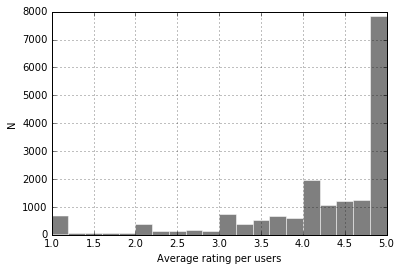

In [59]:
# deep copy 'reviews' data frame 
df = reviews.copy()
df['good'] = df.Score >= 4

# group by user id
grp = df.groupby('UserId')
counts = grp.UserId.count()
means = grp.Score.mean()

means[counts > 5 ].hist(bins=20, edgecolor='w', lw=1, color='k', alpha=0.5)
plt.xlabel("Average rating per users")
plt.ylabel("N")

In [61]:
from sklearn.feature_extraction.text import CountVectorizer


In [62]:
def make_xy(reviews, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(reviews.Text)
    X = X.tocsc()  # some versions of sklearn return COO format
    #y = (reviews.label == 'good').values.astype(np.int)
    y = (reviews.Score >= 4).values.astype(np.int)
    
    return X, y

X, y = make_xy(reviews)

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y)
clf = MultinomialNB().fit(xtrain, ytrain)
print "MN Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest))

MN Accuracy: 87.63%


In [65]:
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %f" % (training_accuracy)
print "Accuracy on test data:     %f" % (test_accuracy)

Accuracy on training data: 0.887027
Accuracy on test data:     0.876282


In [66]:
from sklearn.cross_validation import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [67]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    bad = y == 0
    good = ~bad
    
    return prob[bad, 0].sum() + prob[good, 1].sum()

In [68]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(reviews.shape[0]), train_size=0.7)
mask=np.ones(reviews.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [69]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3]

In [70]:
#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(reviews, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        print "alpha: %f \t dfs: %f\t cv score: %f" % (alpha, min_df, cvscore)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

alpha: 0.000000 	 dfs: 0.000010	 cv score: nan
alpha: 0.000000 	 dfs: 0.000100	 cv score: nan
alpha: 0.000000 	 dfs: 0.001000	 cv score: -42291.638767
alpha: 0.100000 	 dfs: 0.000010	 cv score: -43918.849229
alpha: 0.100000 	 dfs: 0.000100	 cv score: -44150.124318
alpha: 0.100000 	 dfs: 0.001000	 cv score: -42290.326397
alpha: 1.000000 	 dfs: 0.000010	 cv score: -43945.491622
alpha: 1.000000 	 dfs: 0.000100	 cv score: -44163.373633
alpha: 1.000000 	 dfs: 0.001000	 cv score: -42278.418341
alpha: 5.000000 	 dfs: 0.000010	 cv score: -43320.943186
alpha: 5.000000 	 dfs: 0.000100	 cv score: -44167.511955
alpha: 5.000000 	 dfs: 0.001000	 cv score: -42223.106732
alpha: 10.000000 	 dfs: 0.000010	 cv score: -43356.909146
alpha: 10.000000 	 dfs: 0.000100	 cv score: -43981.721157
alpha: 10.000000 	 dfs: 0.001000	 cv score: -42147.646556
alpha: 50.000000 	 dfs: 0.000010	 cv score: -123599.144347
alpha: 50.000000 	 dfs: 0.000100	 cv score: -44022.351921
alpha: 50.000000 	 dfs: 0.001000	 cv score: -

In [71]:
#Later change alpha and df  because the last one ...

print "best alpha: %f" % best_alpha
print "best min_df: %f" % best_min_df

best alpha: 50.000000
best min_df: 0.001000


In [74]:
#set alphas again.. for choosing better parameter
#alphas = [0, .1, 1, 5, 10, 50]
alphas_2 = [50, 100, 150, 200]
#min_dfs = [1e-5, 1e-4, 1e-3]

#best_alpha = None
#best_min_df = None
#maxscore=-np.inf

In [75]:
for alpha in alphas_2:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(reviews, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        print "alpha: %f \t dfs: %f\t cv score: %f" % (alpha, min_df, cvscore)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

alpha: 50.000000 	 dfs: 0.000010	 cv score: -123599.144347
alpha: 50.000000 	 dfs: 0.000100	 cv score: -44022.351921
alpha: 50.000000 	 dfs: 0.001000	 cv score: -41286.302868
alpha: 100.000000 	 dfs: 0.000010	 cv score: -270356.019479
alpha: 100.000000 	 dfs: 0.000100	 cv score: -61758.866824
alpha: 100.000000 	 dfs: 0.001000	 cv score: -39944.336342
alpha: 150.000000 	 dfs: 0.000010	 cv score: -389037.727639
alpha: 150.000000 	 dfs: 0.000100	 cv score: -95652.647946
alpha: 150.000000 	 dfs: 0.001000	 cv score: -39000.133877
alpha: 200.000000 	 dfs: 0.000010	 cv score: -481789.443414
alpha: 200.000000 	 dfs: 0.000100	 cv score: -136909.491834
alpha: 200.000000 	 dfs: 0.001000	 cv score: -39019.621510


In [76]:
# show again 

print "best alpha: %f" % best_alpha
print "best min_df: %f" % best_min_df

best alpha: 150.000000
best min_df: 0.001000


In [ ]:
# go on ...

In [77]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(reviews, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %f" % (training_accuracy)
print "Accuracy on test data:     %f" % (test_accuracy)

Accuracy on training data: 0.865276
Accuracy on test data:     0.865273


In [103]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:30]]
bad_words = words[ind[-30:]]

good_prob = probs[ind[:30]]
bad_prob = probs[ind[-30:]]

print "Top 30 informative words \t     P(good | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "---------------------------------------------------------"
print "Bottom 30 informative words\t     P(good | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Top 30 informative words 	     P(good | word)
             perfect 0.95
              hooked 0.95
              highly 0.95
           delicious 0.94
                 yum 0.94
               yummy 0.93
           excellent 0.93
               loves 0.93
             awesome 0.93
          pleasantly 0.92
                beat 0.92
           wonderful 0.92
             pleased 0.92
               keeps 0.92
               thank 0.92
               great 0.92
                best 0.91
                easy 0.91
             amazing 0.91
            favorite 0.91
                glad 0.91
           fantastic 0.91
              smooth 0.91
              stores 0.91
           favorites 0.91
              thanks 0.91
          refreshing 0.90
               snack 0.90
               bonus 0.90
            training 0.90
---------------------------------------------------------
Bottom 30 informative words	     P(good | word)
         advertising 0.45
         unfortunate 0.45
               b

In [192]:
# if prob >= 0.5 : good
# if prob <  0.5 : bad

# not rank 1~5 , just good or bad problem is even Not valid.
# the main problem is that it just check number of each word, not combination of two words.
# below example will show that.

print "#You can see Weight of each word is not same, Perfect is more effective"
print "word 'perfect' = ", clf.predict_proba(vectorizer.transform(["perfect"]))[0][1]
print "word 'good'    = ", clf.predict_proba(vectorizer.transform(["good"]))[0][1]
print "\n"

print "#'not bad' means neutral, or good, but in this algorithm it is worst than bad because just 'not' is bad"
print "word 'bad'      = ", clf.predict_proba(vectorizer.transform(["bad"]))[0][1]
print "word 'not bad'  = ", clf.predict_proba(vectorizer.transform(["not bad"]))[0][1]
print "\n"

# we should change 'not' + 'somthing' to opposite thing.
# before input sentence to clf.predict, we should search and change the sentence.

# later, it should add ...

# now i have only few things...
# 'not good' -> 'bad'
# 'not bad' -> 'good'

#You can see Weight of each word is not same, Perfect is more effective
word 'perfect' =  0.949390881109
word 'good'    =  0.829771778561


#'not bad' means neutral, or good, but in this algorithm it is worst than bad because just 'not' is bad
word 'bad'      =  0.572312219961
word 'not bad'  =  0.450112837415


word g =  0.572312219961
word 'bad'  =  0.450112837415
#If bad word is add, total probability will 
[[ 0.31480541  0.68519459]]
[1]
[[ 0.42768778  0.57231222]]
[1]


In [260]:
#change word module 

import re

# below 
bw = ['(not good|no good|not perfect|not better)', 
      '(not bad|no bad)',
      '(don\'t like)']
#      '(not sure)',
#      '(never use)',
#      '(don\'t |didn\'t |doesn\'t |not )']


aw = ['bad',
      'good',
      'hate']
#      'uncertain',
#      'unuse',
#      'un']

st = ['it was not good', 
      'it was not bad', 
      'it is no good no bad',
      'i don\'t like it']


def change_combine_word(beforeWord, afterWord, sentences):
    tempSentences = sentences
    finalSentences = []
    for sentence in tempSentences:
        for bw, aw in zip(beforeWord, afterWord):
            searchWord = re.compile(bw)              #find target word
            sentence = searchWord.sub(aw,sentence)   #change target word
        finalSentences.append(sentence)
    
    return finalSentences


In [261]:
#test chnage_combine_word function.
afterSentences = change_combine_word(bw, aw, st)

for bsent, asent in zip(st, afterSentences):
    print "before sentence : ", bsent
    print "after  sentence : ", asent
    print "================================="

before sentence :  it was not good
after  sentence :  it was bad
before sentence :  it was not bad
after  sentence :  it was good
before sentence :  it is no good no bad
after  sentence :  it is bad good
before sentence :  i don't like it
after  sentence :  i hate it


In [255]:
# for original data

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %f" % (training_accuracy)
print "Accuracy on test data:     %f" % (test_accuracy)

Accuracy on training data: 0.865276
Accuracy on test data:     0.865273


In [264]:
# for changed data
changed_reviews = reviews

changed_reviews.Text = change_combine_word(bw, aw, changed_reviews.Text)

print changed_reviews.head()

   Id   ProductId          UserId                      ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score        Time                Summary                                               Text
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian                     1                       1      5  1303862400  Good Quality Dog Food  I have bought several of the Vitality canned d...
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa                     0                       0      1  1346976000      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"                     1                       1      4  1219017600  "Delight" says it all  This is a confection that has been around a fe...
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl                     3                       3      2  1307923200         Cough Medicine  If you are looking f

In [265]:
changed_X, changedy = make_xy(changed_reviews)

changed_itrain, changed_itest = train_test_split(xrange(changed_reviews.shape[0]), train_size=0.7)
changed_mask=np.ones(changed_reviews.shape[0], dtype='int')
changed_mask[changed_itrain]=1
changed_mask[changed_itest]=0
changed_mask = (changed_mask==1)

In [266]:
for alpha in alphas_2:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(changed_reviews, vectorizer)
        Xtrainthis=Xthis[changed_mask]
        ytrainthis=ythis[changed_mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        print "alpha: %f \t dfs: %f\t cv score: %f" % (alpha, min_df, cvscore)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

alpha: 50.000000 	 dfs: 0.000010	 cv score: -123777.886275
alpha: 50.000000 	 dfs: 0.000100	 cv score: -43907.943712
alpha: 50.000000 	 dfs: 0.001000	 cv score: -41217.091365
alpha: 100.000000 	 dfs: 0.000010	 cv score: -270731.070316
alpha: 100.000000 	 dfs: 0.000100	 cv score: -61753.686291
alpha: 100.000000 	 dfs: 0.001000	 cv score: -39909.201368
alpha: 150.000000 	 dfs: 0.000010	 cv score: -389453.581932
alpha: 150.000000 	 dfs: 0.000100	 cv score: -95809.399236
alpha: 150.000000 	 dfs: 0.001000	 cv score: -38989.424920
alpha: 200.000000 	 dfs: 0.000010	 cv score: -482177.034372
alpha: 200.000000 	 dfs: 0.000100	 cv score: -137130.241230
alpha: 200.000000 	 dfs: 0.001000	 cv score: -39024.854488


In [267]:
# select best_alpha and best_min_df in Changed Space !

print "best alpha: %f" % best_alpha
print "best min_df: %f" % best_min_df

best alpha: 150.000000
best min_df: 0.001000


In [268]:
vectorizer = CountVectorizer(min_df=best_min_df)
changed_X, changed_y = make_xy(changed_reviews, vectorizer)
changed_xtrain=X[changed_mask]
changed_ytrain=y[changed_mask]
changed_xtest=X[~changed_mask]
changed_ytest=y[~changed_mask]

clf = MultinomialNB(alpha=best_alpha).fit(changed_xtrain, changed_ytrain)

# Your code here. Print the accuracy on the test and training dataset
changed_training_accuracy = clf.score(changed_xtrain, changed_ytrain)
changed_test_accuracy = clf.score(changed_xtest, changed_ytest)

print "Accuracy on training data: %f" % (changed_training_accuracy)
print "Accuracy on test data:     %f" % (changed_test_accuracy)

Accuracy on training data: 0.865346
Accuracy on test data:     0.864780


In [ ]:
# result show that
# original :
# Accuracy on training data: 0.865276
# Accuracy on test data:     0.865273

# changed :
#Accuracy on training data: 0.865346
#Accuracy on test data:     0.864780

# didn;t changed alot...
# but if there are enough before -> after word data
# it will be better i think ...
# the algorithm is finished

In [195]:
#=============================================================================================

# reference all word 

temWord = words[ind]
for pr in temWord:
    print pr
print len(words)

perfect
hooked
highly
delicious
yum
yummy
excellent
loves
awesome
pleasantly
beat
wonderful
pleased
keeps
thank
great
best
easy
amazing
favorite
glad
fantastic
smooth
stores
favorites
thanks
refreshing
snack
bonus
training
helps
lunch
magnesium
love
carry
carrying
salads
addictive
rich
happy
skeptical
addicted
friends
calm
perfectly
recommended
fast
adds
coat
quick
satisfying
guilt
afternoon
worry
staple
works
subscribe
fabulous
cold
family
easier
evening
dessert
delighted
terrific
stir
cook
satisfied
craving
auto
everyday
recipes
yogurt
soothing
beautiful
breakfast
reasonable
anytime
morning
always
tasty
lasts
keep
affordable
healthy
purse
add
bread
everyone
nice
amazed
picky
matcha
heaven
winner
makes
husband
whenever
sprinkle
sandwiches
enjoys
smoothies
snacking
wait
ice
meals
mom
cooking
homemade
dishes
unique
fits
convenient
addicting
freezer
sometimes
snacks
kids
share
continue
enjoy
home
pancakes
satisfy
helped
wonderfully
finding
toast
without
night
recommend
flavorful
fresh
gi

In [ ]:
# finish !
# now i have not enough data of opposite words. like 'don't like' -> 'hate' , 'not good' -> 'bad'
# but if i have enough dictionary data.. then i will add it on'beforeWord' and 'afterWord' list
# then it will be better accuracy .

